## On the Practicality of Neural Nets for Time Series Regression

In [20]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [21]:
print("Torch version:", torch.__version__)

Torch version: 1.10.1


## Introduction

The article meant as a short guide and introduction to the design and implementation of a basic neural net for time series forecasting. **Time series forecasting can be considered as a sequential machine learning regression problem, in which the sequence data is converted into a series of feature values and the corresponding true or target value.** 

In recent years, the use of Deep Learning for Time Series Analysis and Forecasting has been increased to resolve the problem statements, where we couldn’t be handled using Machine Learning techniques. Let’s discuss briefly.

Advantages 	Disadvantages 
It has the special feature that it would remember every each information, so RNN is much useful for time series prediction	The big challenge is during the training period.
Perfect for creating complex patterns from the input time series dataset.	Expensive computation cost
Fast in prediction/forecasting	
Not affected by missing values, so the cleansing process can be limited


## Data

We will be using a dataset containing time indexed information on home sales in 18 American counties from the years of 2011-2021. A sample of the data is shown below:

In [5]:
## import & concat out three housing datasets
path = '/Users/andrewma/Desktop/Stat-Notes/data/'
master = pd.read_csv('data/texas_housing.csv')
df = master[['date','avg_price','county']]
df['date'] = pd.to_datetime(df.date)
df.dropna(inplace=True)
df.head(5)

,date,avg_price,county
0,2011-01-01,74840,Anderson
1,2011-02-01,82615,Anderson
2,2011-03-01,120542,Anderson
3,2011-04-01,109334,Anderson
4,2011-05-01,82932,Anderson


## Data Preprocessing 

In the interests of time and length of this article, we will be glossing over much of the EDA & data cleaning. This cleaning process can be found in the linked article [here](statisticsandrew.wordpress.com) on time series - both projects utilize the same housing dataset. With the assumption of data with proper types and no missing or deprecated values, let's move on to deriving the parameters of our neural net.

Firstly, there appears to be consistent upward trends for average price across all counties; after an additive decomposition alongside an Augmented Dicket Fuller test on the residuals, we have shown in [this previous article](statisticsandrew.wordpress.com) that avg_price is indeed stationary and has seasonal effect which must be accounted for in the design stage.

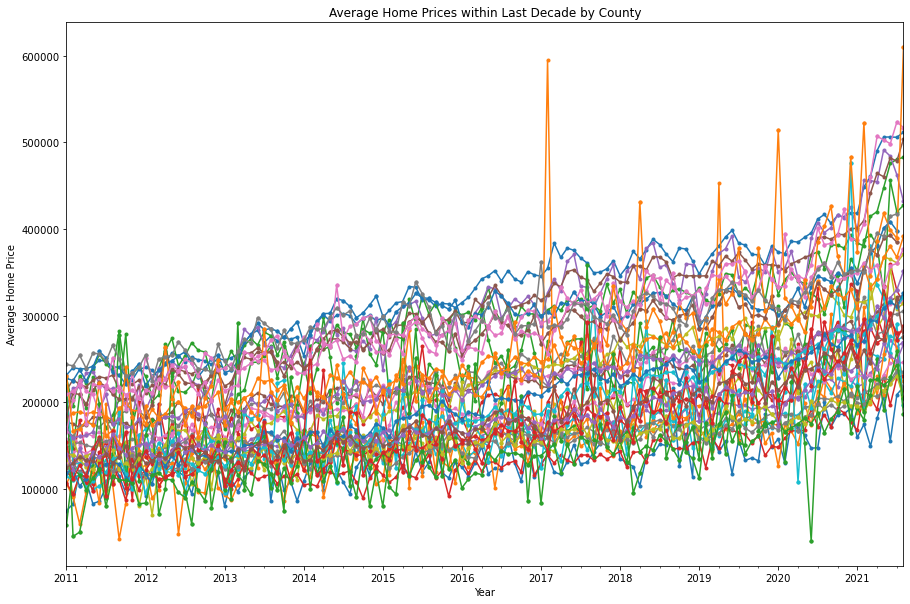

In [19]:
## time series plot for all counties
fig, ax = plt.subplots(figsize=(15,10))
for i, g in df.sort_values('date').groupby('county'):
    g.plot(x='date', y='avg_price', ax=ax, label=str(i), legend = False, marker = '.')

plt.title('Average Home Prices within Last Decade by County')
plt.xlabel('Year')
plt.ylabel('Average Home Price')
plt.show()

## Design & Development

After exploring the stationary and seasonality properties of our time series in question, we can begin to construct a basic neural net that is applicable to nonlinear regression. To answer this question, 

We will follow a window or buffer approach in which we would have to consider an appropriate window size. Then we would move the window from left to right of the sequence or the series data. We will consider the value immediately to right of the window frame as target or the true value. So, each time-step we will shift or move the window so as to get a new row of features values and target value pairs. In this way we form the training data and training labels. In a similar way, we form the test and the validation dataset, which is typically required for a machine learning prediction model. Also, remember that for a predictive model, having a wider observation window and a narrow prediction window can give better results. Next, for the train-test-validation split ratio we will have to figure that out based on the size of the data. For this example I have used a split ratio of 0.8 and based on the seasonality of the data, we have taken a window size of 60. But these variables are all hyper-parameters, which requires some tuning to get the best possible results.

In [9]:
df[df['date'] == '2011-01-01']

,date,avg_price,county
0,2011-01-01,74840,Anderson
128,2011-01-01,105513,Angelina
256,2011-01-01,177212,Aransas
384,2011-01-01,181812,Austin
512,2011-01-01,142613,Bell
640,2011-01-01,176314,Bexar
768,2011-01-01,157068,Brazoria
896,2011-01-01,167360,Brazos
1024,2011-01-01,142400,Caldwell
1152,2011-01-01,124106,Cameron


In [194]:
## split into training & testing for Time series methods
## test = ~20% of data consisting most recent dates, train = all other data
## X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size = 0.2)

## Deep Neural Net

The ability of deep neural nets for . To impute a lag variable into our neural net, we will 

Now, as a best practice for Deep Neural Network training, it is always advisable to shuffle the training data and training in mini-batches instead of one at a time per epoch. For this reason, we will use a time series data generator routine, that creates the required pairs of feature values and target values and does the necessary random shuffling.

In [186]:
df = df.set_index('date')
df

,avg_price,county
date,,
2011-01-01,74840,Anderson
2011-02-01,82615,Anderson
2011-03-01,120542,Anderson
2011-04-01,109334,Anderson
2011-05-01,82932,Anderson
...,...,...
2021-03-01,375223,Montgomery
2021-04-01,395080,Montgomery
2021-05-01,391657,Montgomery


To build and dpeloy a deep neural net, let's consturct a neural network with 4 layers: one for data normalization, two activation layers, and one prediction layer. 

After builidng this 

Now we can test our predictions against the actual test data we had set aside: 

In conclusion, Normalization layers in the model often helps to speed up and stabilize the learning process. If training with large batches isn't an issue and if the network doesn't have any recurrent connections, Batch Normalization could be used. With normalized data, we receive much better estimates of average home prices; our neural net seems to product safe weight estimates for this model. I suspect that there is a risk to increasing the number of epochs, window, or trianing data as that will surely lead to an increase in the variance of our estimates and the 

## Discussion

As we can see from the plots of errirs above, our predications are actually pretty far off the true avergae prices across all counties. I believe that this is a classic example of the **Curse of dimensionality**. In essence, we are exploring this as a $n^4$ problem, where each interval of time is associated with . However, opportunies of parralelization are prevalent within the framework of neural nets.

**Since forecast can never be accurate, one should strive to keep forecasts within confidence intervals or error bands.**

For those who wish to dive deeper into the relationshio between Deep Neural Nets and Time Series Forecasting, 

## References

1. Bhattacharya, Aditya. “Time Series Forecasting Using Tensorflow and Deep Hybrid Learning.” Medium, Towards Data Science, 19 Apr. 2021, https://towardsdatascience.com time-series-forecasting-using-tensorflow-and-deep-hybrid-learning-5088ad76dd55. 
2. “Time Series Tips and Tricks.” Aditya Bhattacharya, 11 July 2020, https://aditya-bhattacharya.net/2020/07/11/time-series-tips-and-tricks/2/. 
3. Brownlee, Jason. “Loss and Loss Functions for Training Deep Learning Neural Networks.” Machine Learning Mastery, 22 Oct. 2019, https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/. 
4. https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-to-time-series-analysis/